# 2-3

In [63]:
from ModifiedEffi import ModifiedEfficientNetV2S
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import time
import torch
from torchsummary import summary
import random 
import matplotlib.pyplot as plt
import numpy as np

In [64]:
# model = ModifiedEfficientNetV2S()
# summary = summary(model, (3, 224, 224))
# summary

Setup Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# root_path = '/home/ctsai67/EEE598/Assignment\ 3/P2'
root_path = ''

# Load and Split the data
dataset_train = Flowers102(root=root_path, download=True, split='train', transform=transform)
dataset_test = Flowers102(root=root_path, download=False, split='test', transform=transform)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
model = 
model = ModifiedEfficientNetV2S().eval()
# model = torch.nn.DataParallel(model)
model = model.to(device)

# Define Loss function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/homebrew/Caskroom/miniforge/base/envs/DP/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/DP/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Implement training loop

In [66]:
# Time tracking
start_time = time.time()

# Train the model
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0
    total = 0
    correct = 0

    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predict = output.max(1)
        total += label.size(0)
        correct += predict.eq(label).sum().item()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


# Training time
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

KeyboardInterrupt: 

In [ ]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
print("\n\nLast 7 lines of torchsummary:")

# Print the last 7 lines of the summary
import io
import sys
output = io.StringIO()
sys.stdout = output

# Model summary
summary(model, (3, 224, 224))

# Reset the stdout
sys.stdout = sys.__stdout__

# Get the captured output and split it into lines
output_str = output.getvalue()
output_lines = output_str.split('\n')
# Print the last 7 lines
for line in output_lines[-8:-1]:  # -8 to -1 to avoid last empty line
    print(line)

# 2-5
Create my own image augmentation technique.

In [88]:
def random_patch_erasing(images, max_patch_size=0.2):
    """Applies random patch erasing to an image or batch of images."""
    if images.ndim == 4:  # Batch of images [B, C, H, W]
        batch_size, channels, height, width = images.shape

        for i in range(batch_size):
            # Randomly determine the size and position of the patch
            erase_h = random.randint(1, int(height * max_patch_size))
            erase_w = random.randint(1, int(width * max_patch_size))
            y = random.randint(0, height - erase_h)
            x = random.randint(0, width - erase_w)

            # Generate a random patch with the same number of channels
            random_patch = torch.randint(0, 256, (channels, erase_h, erase_w), dtype=torch.uint8).float() / 255.0

            # Assign the random patch to the selected region of the image
            images[i, :, y:y+erase_h, x:x+erase_w] = random_patch.to(images.dtype)

    elif images.ndim == 3:  # Single image [C, H, W]
        channels, height, width = images.shape

        # Randomly determine the size and position of the patch
        erase_h = random.randint(1, int(height * max_patch_size))
        erase_w = random.randint(1, int(width * max_patch_size))
        y = random.randint(0, height - erase_h)
        x = random.randint(0, width - erase_w)

        # Generate a random patch with the same number of channels
        random_patch = torch.randint(0, 256, (channels, erase_h, erase_w), dtype=torch.uint8).float() / 255.0

        # Assign the random patch to the selected region of the image
        images[:, y:y+erase_h, x:x+erase_w] = random_patch.to(images.dtype)

    else:
        raise ValueError("Input images must have 3 or 4 dimensions")

    return images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4285715].


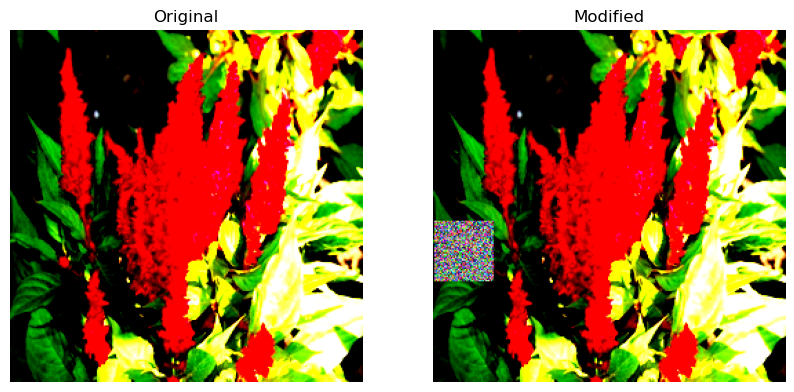

In [92]:
# Get the original image and label
rand_index = random.randint(0, len(dataset_train))
image, label = dataset_test[rand_index]  # Get the data sample

# Apply random patch erasing
image_modified = random_patch_erasing(image.clone())  # Clone to avoid altering the original data

# Convert the images to [H, W, C] format and NumPy for visualization
image_np = image.permute(1, 2, 0).numpy()  # Convert [C, H, W] -> [H, W, C]
image_modified_np = image_modified.permute(1, 2, 0).numpy()  # Convert [C, H, W] -> [H, W, C]

# Plot original and modified images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(image_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title('Modified')
plt.imshow(image_modified_np)
plt.axis("off")

plt.show()


In [76]:
import time

# Time tracking
start_time = time.time()

# Train the model
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0
    total = 0
    correct = 0

    for images, labels in train_loader:
        # Move data to the appropriate device
        images, labels = images.to(device), labels.to(device)

        # Apply random patch erasing (ensure no dimension change)
        images = random_patch_erasing(images.clone())  # Shape remains [B, C, H, W]

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Accuracy: {100 * correct / total:.2f}%")

# Training time
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        # Move data to the appropriate device
        images, labels = images.to(device), labels.to(device)

        # Forward pass (no augmentation applied here)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Test Accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/2], Loss: 5.6647, Accuracy: 0.78%
Epoch [2/2], Loss: 4.4445, Accuracy: 2.25%
Training time: 3355.90 seconds
Test Accuracy: 2.31%
